In [1]:
# Imports
# Micellanious
import numpy as np
# Load observational data
import pandas as pd
import astropy.units as u
# Load spectra
from synphot import SourceSpectrum, units, SpectralElement, Observation
from synphot.models import Empirical1D
from specutils.spectra import Spectrum1D
# Plots
import matplotlib.pyplot as plt
# Fitting
import warnings
from specutils.manipulation import median_smooth
from specutils.spectra import SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum
from astropy.modeling.models import Chebyshev1D, Const1D, Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

## Load obs data and reference spectrum

There are two types of flux units:
* erg s^-1 cm^-2 A^-1 == FLAM
* photons s^-1 cm^-2 A^-1 == PHOTLAM --- this is what we observe, but the detector flux number is this multiplied by the area of the telescope! so we need to divide when writing the spectrum.

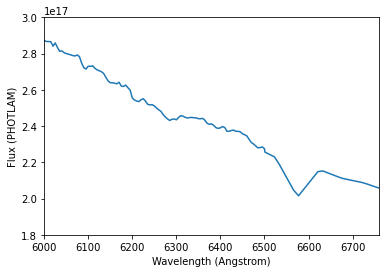

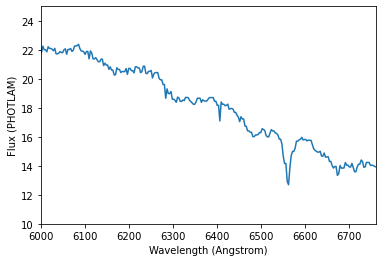

In [2]:
# Load the files and data

filename_ref = './fhr153.dat'
# see the readme for the definiton of .dat file.
# First column - wavelength in Angstrom
# Second column - in 1e16 erg s^-1 cm^-2 A^-1 == FLAM
# Load with built in function, it expects FLAMs
sp_ref = SourceSpectrum.from_file(filename_ref)
# the built-in plot function plots in PHTOLAM by default
sp_ref.plot(left=6000, right=6760, bottom=0.18e18, top=0.3e18) # plot if you want to examine it
wave_ref = sp_ref.waveset
flux_ref = sp_ref(wave_ref) # this is in PHOTLAM , this samples the spec at the wavelengths

filename_obs = './hr153-zCas-extr-1d-spec.csv'
df_obs = pd.read_csv(filename_obs)
area_telescope = 0.25 * np.pi * 35.56 * 35.56
wave_obs = df_obs['Lambda'].to_numpy() * 1e10 * u.AA
flux_obs = df_obs['Signal'].to_numpy() * units.PHOTLAM / area_telescope
# the flux unit is not real, we just use this to get close numbers
sp_obs = SourceSpectrum(Empirical1D, points=wave_obs, lookup_table=flux_obs, keep_neg=True)
sp_obs.plot(left=6000, right=6760, bottom=10, top=25)

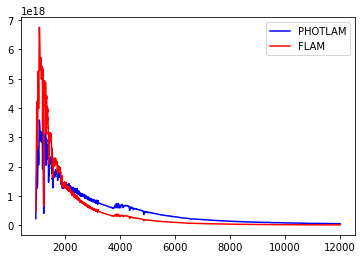

In [3]:
# compare PHTOLAM and FLAM units

plt.plot(wave_ref, flux_ref, 'b', wave_ref, sp_ref(wave_ref, flux_unit=units.FLAM)*1e11, 'r')
plt.legend(["PHOTLAM", "FLAM"])
# sp_obs.plot(left=6000, right=6760)

# plt.plot(wave_ref, flux_ref, 'b', wave_obs, sp_ref(wave_obs),'r')
# # plt.plot(wave_obs, flux_obs, 'g')
# # # plt.xlim(5000, 8000)
# plt.ylim(-0.1e18, 0.4e18)

In [4]:
# Procedure to fit the reference

# To work with the fitting, convert to specutils Spectrum1D
spec1d_ref = sp_ref.to_spectrum1d(wavelengths=wave_obs, flux_unit=units.FLAM)
print(spec1d_ref)
# smoothening to remove cosmic rays; increase WIDTH until removed
# TODO improve to do properly, not this stupid way
# spec1d = median_smooth(spec1d_raw, width=7)

# # plot to see loaded spectrum
# ax = plt.subplots()[1]
# ax.plot(spec1d_ref.spectral_axis, spec1d_ref.flux)
# # ax.set_xlim(5100,6760)
# ax.set_ylim(0,2e6)

# regions of continuum in the original spectrum - these are to be fitted on
# PICK SUCH THAT YOU GO AROUND SPECTRAL LINES - USE PLOT ABOVE
region_ref = [
    (5200*u.AA, 5800*u.AA),
    (5900*u.AA, 6500*u.AA),
    (6760*u.AA, 8600*u.AA)
]

# produce the fit on the continuum using the regions provided above
# to get the best fit, modify the MODEL orded of the Chebyshev polynomials
# WARNING: take care NOT TO overfit the spectrum, so increase order carefully
# NB: it is better to use odd order of polynomials (#TODO expand on why exactly)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # here, g1_fit produces a model; see below for use
    g1_fit_ref = fit_continuum(spec1d_ref, model=Chebyshev1D(3), window=region_ref)

# g1_fit accepts values for the x-axis and produces the respective values for 
# the y-axis given the fit it calculated
continuum_fit_ref = g1_fit_ref(spec1d_ref.spectral_axis)

# # plot the fit over the raw data
# f, ax = plt.subplots()
# ax.plot(spec1d_ref.spectral_axis, spec1d_ref.flux)
# ax.plot(spec1d_ref.spectral_axis, continuum_fit_ref)
# ax.set_title('Continuum Fitting')
# ax.set_xlim(6000,6760)

spec_norm_ref = spec1d_ref / continuum_fit_ref

# # plot the normalised spectrum to examine the normalised spectrum
# f, ax = plt.subplots()
# ax.plot(spec_norm_ref.spectral_axis, spec_norm_ref.flux)
# ax.set_title('Continuum Fitting')
# ax.set_xlim(6000,6760)
# ax.set_ylim(0.85,1.1)

# Fit around the feature - follow the tutorial from the synphot tutorials page
norm_wave_ref = spec_norm_ref.spectral_axis
norm_flux_ref = spec_norm_ref.flux
mask_ref = (norm_wave_ref >= 6350*u.AA) & (norm_wave_ref <= 6760*u.AA)
x_ref = norm_wave_ref[mask_ref]
y_ref = norm_flux_ref[mask_ref]

Spectrum1D (length=1600)
flux:             [ 1.7688e+06 FLAM, ..., 1.7089e+05 FLAM ],  mean=5.9668e+05 FLAM
spectral axis:    [ 5000.0 Angstrom, ..., 9794.0 Angstrom ],  mean=7397.0 Angstrom


In [5]:
# Procedure to fit the observation

# To work with the fitting, convert to specutils Spectrum1D
spec1d_obs = sp_obs.to_spectrum1d(wavelengths=wave_obs, flux_unit=units.FLAM)
print(spec1d_obs)
# smoothening to remove cosmic rays; increase WIDTH until removed
# TODO improve to do properly, not this stupid way
# spec1d = median_smooth(spec1d_raw, width=7)

# # plot to see loaded spectrum
# ax = plt.subplots()[1]
# ax.plot(spec1d_obs.spectral_axis, spec1d_obs.flux)
# ax.set_xlim(5200,6000)
# # ax.set_ylim(0,2e6)

# regions of continuum in the original spectrum - these are to be fitted on
# PICK SUCH THAT YOU GO AROUND SPECTRAL LINES - USE PLOT ABOVE
region_obs = [
    (5200*u.AA, 5800*u.AA),
    (5950*u.AA, 6550*u.AA),
    (7700*u.AA, 9500*u.AA)
]

# produce the fit on the continuum using the regions provided above
# to get the best fit, modify the MODEL orded of the Chebyshev polynomials
# WARNING: take care NOT TO overfit the spectrum, so increase order carefully
# NB: it is better to use odd order of polynomials (#TODO expand on why exactly)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # here, g1_fit produces a model; see below for use
    # 5th order chebyshev to fit it well to continuum, plot to see difference
    g1_fit_obs = fit_continuum(spec1d_obs, model=Chebyshev1D(5), window=region_obs)

# g1_fit accepts values for the x-axis and produces the respective values for 
# the y-axis given the fit it calculated
continuum_fit_obs = g1_fit_obs(spec1d_obs.spectral_axis)

# # plot the fit over the raw data to examine the normalised spectrum if the fit
# # is good or the polynomial needs adjusting
# f, ax = plt.subplots()
# ax.plot(spec1d_obs.spectral_axis, spec1d_obs.flux)
# ax.plot(spec1d_obs.spectral_axis, continuum_fit_obs)
# ax.set_title('Continuum Fitting')
# ax.set_xlim(6000,6760)

spec_norm_obs = spec1d_obs / continuum_fit_obs

# # plot the normalised spectrum to examine the normalised spectrum if the fit
# # is good or the polynomial needs adjusting
# f, ax = plt.subplots()
# ax.plot(spec_norm_obs.spectral_axis, spec_norm_obs.flux)
# ax.set_title('Continuum Fitting')
# ax.set_xlim(6550,6570)
# ax.set_ylim(0.75,1.1)

# Fit around the feature - follow the tutorial from the synphot tutorials page
# Fit around the feature - follow the tutorial from the synphot tutorials page
norm_wave_obs = spec_norm_obs.spectral_axis
norm_flux_obs = spec_norm_obs.flux
mask_obs = (norm_wave_obs >= 6350*u.AA) & (norm_wave_obs <= 6760*u.AA)
x_obs = norm_wave_obs[mask_obs]
y_obs = norm_flux_obs[mask_obs]

Spectrum1D (length=1600)
flux:             [ 0.0 FLAM, ..., 0.0 FLAM ],  mean=3.1253e-11 FLAM
spectral axis:    [ 5000.0 Angstrom, ..., 9794.0 Angstrom ],  mean=7397.0 Angstrom


6572.892079130815
6559.9202813265465


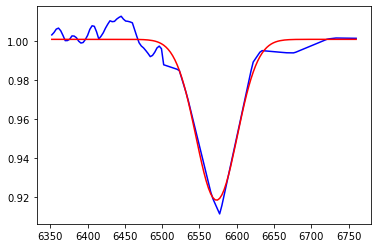

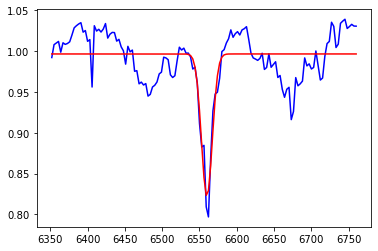

In [6]:
# Fit Gaussians to the normalised spectra to find centre of absorpt line
fitter = LevMarLSQFitter()

bg_ref = Const1D(amplitude=1)
gs_ref = Gaussian1D(amplitude=1, mean=6570, stddev=1)
init_model_ref = bg_ref - gs_ref

fit_model_ref = fitter(init_model_ref, x_ref, y_ref)
y_fit_ref = fit_model_ref(x_ref)
lambda_ref = fit_model_ref[1].mean.value
print(lambda_ref)

fig, ax = plt.subplots()
ax.plot(x_ref,y_ref,'b',x_ref,y_fit_ref,'r')

bg_obs = Const1D(amplitude=1)
gs_obs = Gaussian1D(amplitude=1, mean=6560, stddev=1)
init_model_obs = bg_obs - gs_obs

fit_model_obs = fitter(init_model_obs, x_obs, y_obs)
y_fit_obs = fit_model_obs(x_obs)
lambda_obs = fit_model_obs[1].mean.value
print(lambda_obs)

fig, ax = plt.subplots()
ax.plot(x_obs,y_obs,'b',x_obs,y_fit_obs,'r')

(0.75, 1.1)

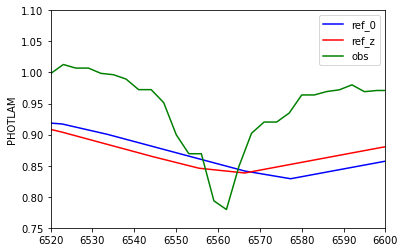

In [7]:
# calculate the redshift

z1 = (lambda_obs - lambda_ref)/lambda_ref
sp_ref_z1 = SourceSpectrum(sp_ref.model, z=z1, z_type="conserve_flux")
# TODO figure out if we should do conserve_flux or not

plt.plot(wave_ref, flux_ref/np.median(flux_ref[(wave_ref>=6000*u.AA)&(wave_ref<=7000*u.AA)]), 'b')
plt.plot(wave_ref,sp_ref_z1(wave_ref)/np.median(sp_ref_z1(wave_ref[(wave_ref>=6000*u.AA)&(wave_ref<=7000*u.AA)])),'r')
plt.plot(wave_obs, flux_obs/np.median(flux_obs[(wave_obs>=6000*u.AA)&(wave_obs<=7000*u.AA)]), 'g')
plt.legend(["ref_0", "ref_z", "obs"])
plt.ylabel("PHOTLAM")
plt.xlim(left=6520, right=6600)
plt.ylim(0.75,1.1)

## Calculate the observational sensitivity of our apparatus

We will make an Bandpass object. We will then use this to compare:
* our observation of the Mars spectrum
* make a dry Observation using the Bandpass object
* divide the two to find the spectral albedo

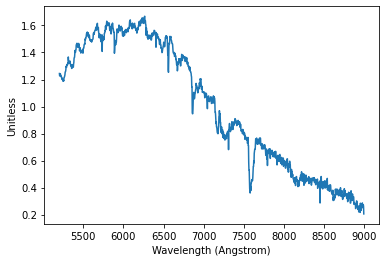

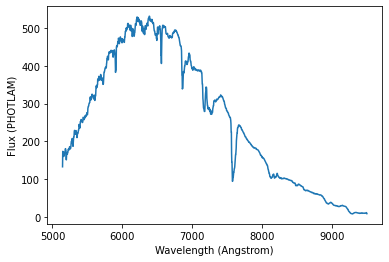

In [8]:
# build the Bandpass with the redshifted reference spectra

bp_raw = sp_obs / sp_ref_z1 * 2e16
# bp_raw.plot()#, bottom=10, top=25)
# bp_raw2 = sp_ref_z1 /sp_obs * 0.5e-16
# bp_raw2.plot(bottom=0, top=5)
wave_obs_cut = wave_obs[(wave_obs>=5200*u.AA)&(wave_obs<=9000*u.AA)]
# hack because the bp_raw doesn't work for some reason
bp = SpectralElement(
    Empirical1D, points = wave_obs_cut, lookup_table=bp_raw(wave_obs_cut),keep_neg=True
)
bp.plot()

# load up mars
filename_mars = './mars-extr-1d-spec.csv'
df_mars = pd.read_csv(filename_mars)
area_telescope = 0.25 * np.pi * 35.56 * 35.56
wave_mars = df_mars['Lambda'].to_numpy() * 1e10 * u.AA
flux_mars = df_mars['Signal'].to_numpy() * units.PHOTLAM / area_telescope
# the flux unit is not real, we just use this to get close numbers
sp_mars = SourceSpectrum(Empirical1D, points=wave_mars, lookup_table=flux_mars, keep_neg=True)
sp_mars.plot()#left=6000, right=6760)#, bottom=10, top=25)

## Calculate the spectral albedo

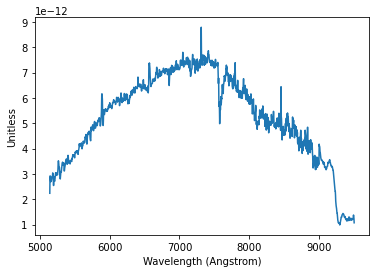

In [9]:
# load the solar spectrum - use another package
from sbpy.calib import Sun
# The Sun class built in this is based on the synphot classes.
# We extract the synphot SourceSpectrum, and continute with our procedure.
sp_sun = Sun.from_default().source
# observe the spectrum in the same range
obs_sun = Observation(sp_sun, bp)
# plt.plot(sp_sun.waveset, sp_sun(sp_sun.waveset), 'b')
# plt.plot(obs_sun.waveset, obs_sun(obs_sun.waveset), 'r')
# plt.xlim(5200,9000)
# # plt.ylim(0,1e10)

albedo = sp_mars / obs_sun.as_spectrum()
albedo.plot()

# Currently the hole at the atmospheric 7500AA stands, need to see if there is some small mistake above that fixes this.
# Look close to literature values, but should be higher at the red end.